In [1]:
from fastai.vision.all import *

In [2]:
def dice(input, targs, iou=False, eps=1e-8,sz=256):
    #threshold for the number of predicted pixels
    noise_th = 75.0*(sz/128.0)**2 
    best_thr0 = 0.2
    n = targs.shape[0]
    #input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = torch.sigmoid(input).view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [3]:
data_path = Path('data/')

In [4]:
data_path.ls()

(#5) [Path('data/dicom-images-test'),Path('data/dicom-images-train'),Path('data/pneumothorax'),Path('data/train-rle.csv'),Path('data/train')]

In [5]:
size=224
bs=64

In [6]:
tfms = [IntToFloatTensor(div_mask=255)]
db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
               batch_tfms=tfms,
               item_tfms=[Resize(size)],
               get_items=get_image_files,get_y=lambda o:str(o).replace('images','mask'))

In [7]:
dls = db.dataloaders(source=data_path/'train'/'images',bs=bs)

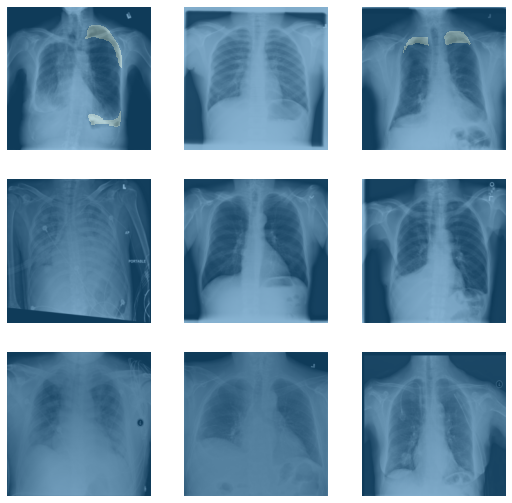

In [8]:
dls.show_batch(max_n=9)

In [12]:
learn = unet_learner(dls, resnet34, n_out=1, loss_func=BCEWithLogitsLossFlat(),metrics=dice)
learn = learn.to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.019776,0.017949,0.774239,00:56


epoch,train_loss,valid_loss,dice,time
0,0.011265,0.013460,0.788817,00:51
1,0.010779,0.014838,0.790749,00:52
2,0.006637,0.010902,0.791381,00:52
3,0.004593,0.013857,0.797306,00:50
4,0.003368,0.015673,0.801210,00:50


In [13]:
!pip install timm

     |████████████████████████████████| 287 kB 5.6 MB/s eta 0:00:01


In [9]:
import timm

In [26]:
# timm.list_models(pretrained=True)

In [28]:
encoder = timm.create_model('resnext50_32x4d', features_only=True, pretrained=True)

In [29]:
inp = torch.rand((6,3,224,224))

In [30]:
out = encoder(inp)

In [31]:
for o in out:
    print(o.shape)

torch.Size([6, 64, 112, 112])
torch.Size([6, 256, 56, 56])
torch.Size([6, 512, 28, 28])
torch.Size([6, 1024, 14, 14])
torch.Size([6, 2048, 7, 7])


In [19]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)
        
    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [20]:
Decoder(2048+1024,512,32) 

Decoder(
  (conv1): ConvLayer(
    (0): Conv2d(3072, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): ConvLayer(
    (0): Conv2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [24]:
class Unet(Module):
    def __init__(self,fs:int=32,):
        pass
    

In [ ]:
class Decoder(Module):
    def __init__(self,in_channels,chanels,out_channels):
        self.conv1 = ConvLayer(in_channels,chanels)
        self.conv2 = ConvLayer(chanels,out_channels)

    def forward(self,x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetResNext50(Module):
    def __init__(self):
        fs = 32
        self.resnext = TGSResNext50()
        self.center = nn.Sequential(ConvLayer(2048,2048),ConvLayer(2048,1024))
        self.decoder5 = Decoder(2048+1024,512,fs)
        self.decoder4 = Decoder(1024+fs,256,fs)
        self.decoder3 = Decoder(512+fs,128,fs)
        self.decoder2 = Decoder(256+fs,64,fs)
        self.decoder1 = Decoder(fs,fs,fs)
        self.logit = nn.Sequential(ConvLayer(fs*5,64),ConvLayer(64,32),nn.Conv2d(32,1,kernel_size=1))

    def forward(self, x):
        e1,e2,e3,e4,e5 = self.resnext(x) #'64 256 512 1024 2048'
        f = self.center(e5)
        d5 = self.decoder5(torch.cat([f, e5], 1))
        d4 = self.decoder4(torch.cat([d5, e4], 1))
        d3 = self.decoder3(torch.cat([d4, e3], 1))
        d2 = self.decoder2(torch.cat([d3, e2], 1))
        d1 = self.decoder1(d2)

        f = torch.cat((
                 d1,
                 F.interpolate(d2, scale_factor=2, mode='bilinear',align_corners=False),
                 F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=False),
                 F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=False),
                 F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False),

        ), 1)

        logit = self.logit(f)
        return logit